In [87]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

## Points to Polygon function 
- <b>dataframe</b>: GeoDataFrame with <code>Point</code> geometry column

In [5]:
def coords_to_polygon(dataframe):
    coords = []
    for row in dataframe.itertuples():
        coords.append(Point(row.Longitude, row.Latitude))
    poly_geom = Polygon(coords)
    gdf = gpd.GeoDataFrame(index=[0], crs=4326, geometry=[poly_geom])
    return gdf

## Decision Trees to Concave Hull function
- <b>parquet_fpath</b>: Parquet file path of decision trees file
- <b>title</b>: Title of the plot
- <b>concave_tightness</b>: 0 is for maximum concaveness, 1 for convex hull

In [6]:
def DT_to_Concave(parquet_fpath, title='DT Concave Hull', concave_tightness=0.6):
    # Reads Decision Trees (DT) Parquet
    df = pd.read_parquet(parquet_fpath)
    # Creates GeoDataFrame with point geometry and sets projection to 4326
    gdf = gpd.GeoDataFrame(data=df, crs=4326, geometry=[Point(row.Longitude, row.Latitude) for row in df.itertuples()])
    # Seperates points 'YES' predicted by decision trees
    gdf_yes = gdf[gdf['decision_tree_predicted']==1]
    gdf_yes_poly = coords_to_polygon(gdf_yes)
    # Extracts point geometry
    gdf_yes_geom = gdf_yes_poly.geometry
    # Generates Concave_hull() by parameters
    hull = gdf_yes_geom.concave_hull(ratio=concave_tightness, allow_holes=False)
    # Creates polygon without fill
    hull.plot(color='#fec44f',edgecolor='#636363')
    # Labels
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
    return hull

## Neural Network to Concave Hull function
- <b>parquet_fpath</b>: Parquet file path of neural network file
- <b>title</b>: Title of the plot
- <b>concave_tightness</b>: 0 is for maximum concaveness, 1 for convex hull

In [82]:
def NN_to_Concave(parquet_fpath, title='NN Concave Hull', concave_tightness=0.6):
    # Reads Decision Trees (DT) Parquet
    df = pd.read_parquet(parquet_fpath)
    # Creates GeoDataFrame with point geometry and sets projection to 4326
    gdf = gpd.GeoDataFrame(data=df, crs=4326, geometry=[Point(row.Longitude, row.Latitude) for row in df.itertuples()])
    # Seperates points 'YES' predicted by decision trees
    gdf_yes = gdf[gdf['normalized_preds']==1]
    gdf_yes_poly = coords_to_polygon(gdf_yes)
    # Extracts point geometry
    gdf_yes_geom = gdf_yes_poly.geometry
    # Generates Concave_hull() by parameters
    hull = gdf_yes_geom.concave_hull(ratio=concave_tightness, allow_holes=False)
    # Creates polygon without fill
    hull.plot(color='#7fcdbb',edgecolor='#636363')
    # Labels
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
    return hull

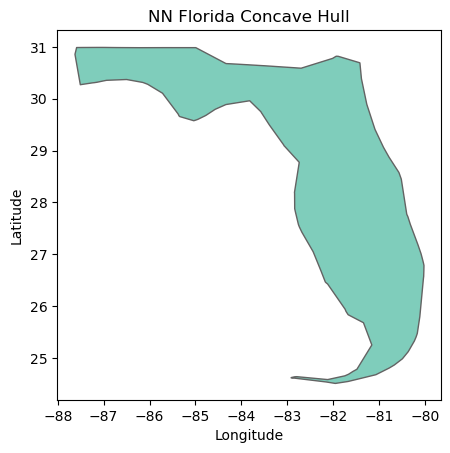

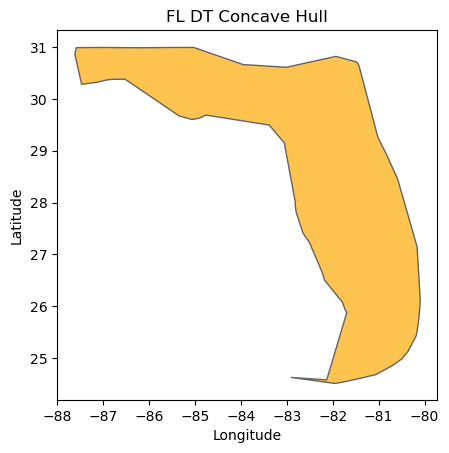

In [8]:
nn_fl = NN_to_Concave(parquet_fpath='all_exc_florida_pred_norm_nn.parquet',title='NN Florida Concave Hull',concave_tightness=0.1)
dt_fl = DT_to_Concave('all_exc_florida_train_florida_pred_dt.parquet',title='FL DT Concave Hull', concave_tightness=0.2)

## Comparitive analysis of Neural Networks and Decision Trees

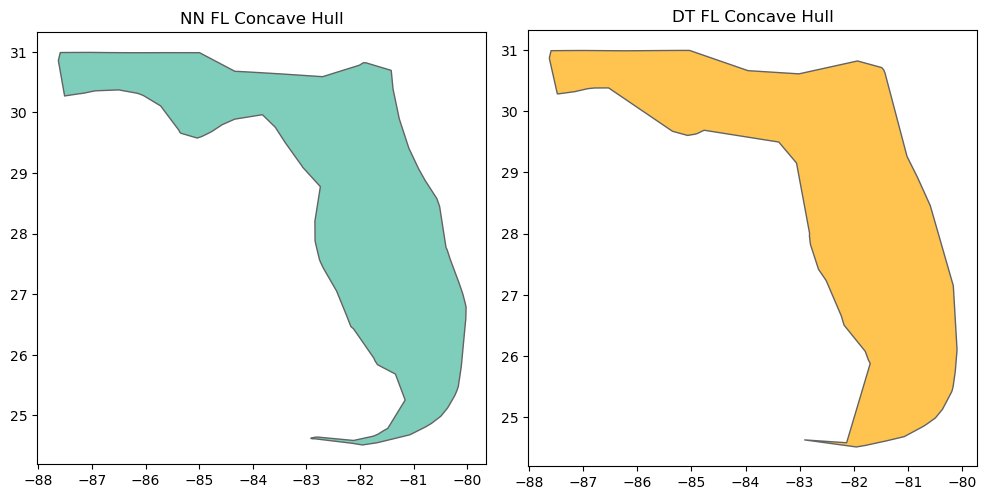

In [94]:
# Create subplots with two columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Neural Networks plot
nn_fl.plot(ax=axs[0],color='#7fcdbb',edgecolor='#636363')
axs[0].set_title(f'NN FL Concave Hull')
# Decision trees plot
dt_fl.plot(ax=axs[1], color='#fec44f',edgecolor='#636363')
axs[1].set_title(f'DT FL Concave Hull')
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

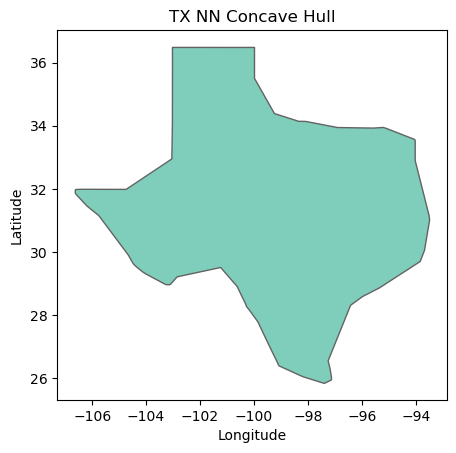

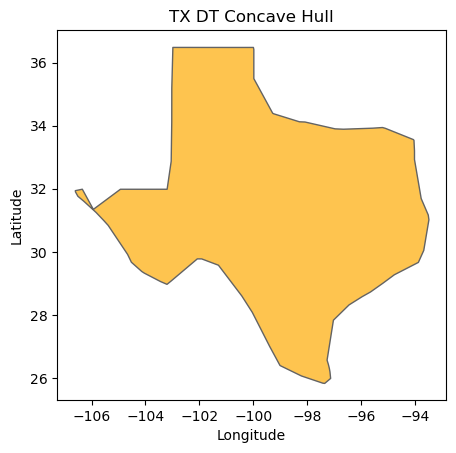

In [12]:
nn_tx = NN_to_Concave(parquet_fpath='texas_pred_normalization.parquet',title='TX NN Concave Hull',concave_tightness=0.3)
dt_tx = DT_to_Concave('all_exc_texas_train_texas_pred_dt.parquet',title='TX DT Concave Hull', concave_tightness=0.2)

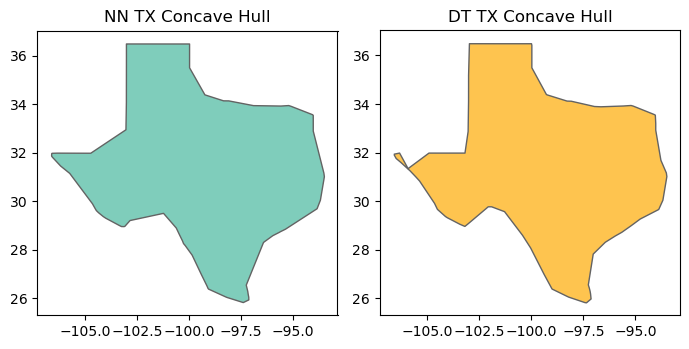

In [17]:
# Create subplots with two columns
fig, axs = plt.subplots(1, 2, figsize=(7, 5))
# Neural Networks plot
nn_tx.plot(ax=axs[0],color='#7fcdbb',edgecolor='#636363')
axs[0].set_title(f'NN TX Concave Hull')
# Decision trees plot
dt_tx.plot(ax=axs[1], color='#fec44f',edgecolor='#636363')
axs[1].set_title(f'DT TX Concave Hull')
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

In [19]:
def df_to_gdf(file):
    try:
        if file.endswith('.csv'):
            df = pd.read_csv(file)
            gdf = gpd.GeoDataFrame(data=df,crs =4326,geometry=[Point(row.Longitude,row.Latitude) for row in df.itertuples()])
            gdf = gdf.set_crs(4326)
            return gdf
        if file.endswith('.parq') or file.endswith('.parquet'):
            df = pd.read_parquet(file)
            gdf = gpd.GeoDataFrame(data=df,crs =4326, geometry=[Point(row.Longitude,row.Latitude) for row in df.itertuples()])
            return gdf
        else:
            print('But yeah !! CSV or Parq is accepted')
    except Exception as error:
        print(f'An error occured:{error}')

In [20]:
def calc_points(gdf1,gdf2):
    return round((len(gdf1)/len(gdf2))*100,2)

## Topfers Algorithm (Level 3)

In [27]:
def create_topfers(data_fpath, column_name='len_forward'):
    # Create GeoDataFrame from a vertices parquet file
    gdf = df_to_gdf(data_fpath)
    # Calculate level 1 mean from GeoDataFrame
    mean_l1 = gdf[column_name].mean()
    # Seperate head and tail based on mean forward length
    head_gdf_l1 = gdf[gdf[column_name] >= mean_l1]
    tail_gdf_l1 = gdf[gdf[column_name] < mean_l1]
    # Calculate head and tail for level 1
    head_l1 = calc_points(head_gdf_l1, gdf)
    tail_l1 = calc_points(tail_gdf_l1, gdf)
    print(f'Level 1: Head ({head_l1}%), Tail ({tail_l1}%)')
    # Calculate level 2 mean from level 1 head GeoDataFrame
    mean_l2 = head_gdf_l1[column_name].mean()
    # Seperate head and tail based on level 2 mean forward length
    head_gdf_l2 = head_gdf_l1[head_gdf_l1[column_name] >= mean_l2]
    tail_gdf_l2 = head_gdf_l1[head_gdf_l1[column_name] < mean_l2]
    # Calculate head and tail for level 2
    head_l2 = calc_points(head_gdf_l2, head_gdf_l1)
    tail_l2 = calc_points(tail_gdf_l2, head_gdf_l1)
    print(f'Level 2: Head ({head_l2}%), Tail ({tail_l2}%)')
    # Calculate level 3 mean from level 2 head GeoDataFrame
    mean_l3 = head_gdf_l2[column_name].mean()
    # Seperate head and tail based on level 3 mean forward length
    head_gdf_l3 = head_gdf_l2[head_gdf_l2[column_name] >= mean_l3]
    tail_gdf_l3 = head_gdf_l2[head_gdf_l2[column_name] < mean_l3]
    # Calculate head and tail for level 3
    head_l3 = calc_points(head_gdf_l3, head_gdf_l2)
    tail_l3 = calc_points(tail_gdf_l3, head_gdf_l2)
    print(f'Level 3: Head ({head_l3}%), Tail ({tail_l3}%)')
    
    return [head_gdf_l1, head_gdf_l2, head_gdf_l3]

In [28]:
maine_topfers = create_topfers(data_fpath='Vertices_Labels/Maine.parq')

Level 1: Head (4.7%), Tail (95.3%)
Level 2: Head (8.86%), Tail (91.14%)
Level 3: Head (38.83%), Tail (61.17%)


In [74]:
def plot_topfers_point(topfers_list):
    # Create subplots with three columns
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # Plot each GeoDataFrame on a separate subplot
    topfers_list[0].plot(ax=axs[0], color='blue')
    axs[0].set_title(f'Level 1 ({len(topfers_list[0])})')
    topfers_list[1].plot(ax=axs[1], color='green')
    axs[1].set_title(f'Level 2 ({len(topfers_list[1])})')
    topfers_list[2].plot(ax=axs[2], color='red')
    axs[2].set_title(f'Level 3 ({len(topfers_list[2])})')
    # Adjust spacing between subplots
    plt.tight_layout()
    # Show the plot
    plt.show()

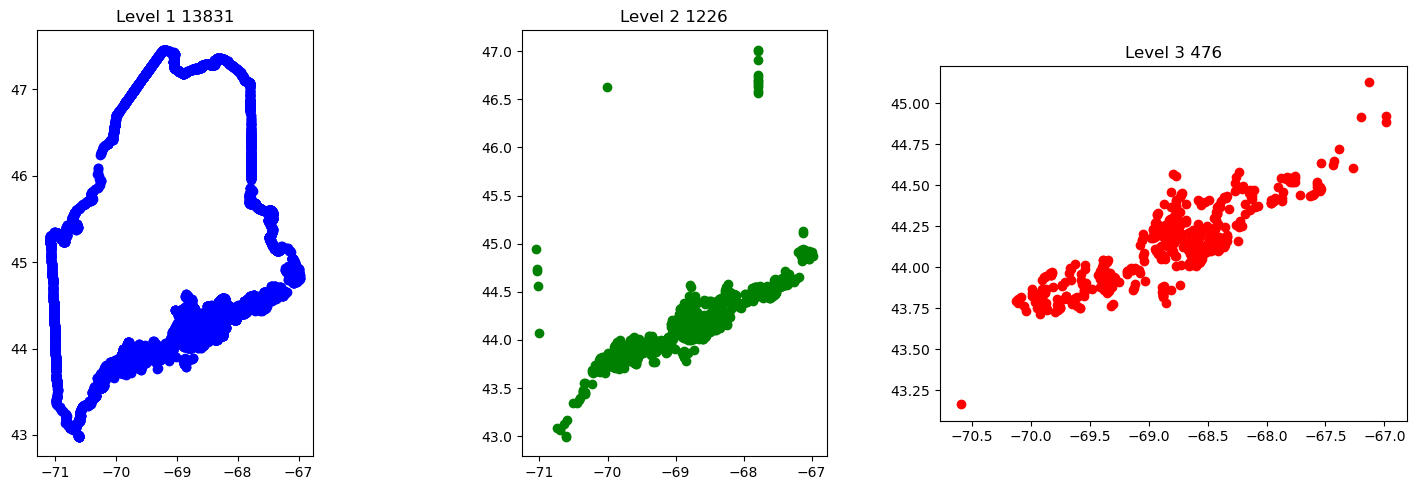

In [75]:
plot_topfers_point(maine_topfers)

In [78]:
def plot_topfers_poly(topfers_list):
    # Create subplots with three columns
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    gdf1 = coords_to_polygon(topfers_list[0])
    gdf2 = coords_to_polygon(topfers_list[1])
    gdf3 = coords_to_polygon(topfers_list[2])
    # Plot each GeoDataFrame on a separate subplot
    gdf1.plot(ax=axs[0], color='#fff7bc', edgecolor='#252525')
    axs[0].set_title(f'Level 1 ({len(topfers_list[0])})')
    gdf2.plot(ax=axs[1], color='#fec44f', edgecolor='#252525')
    axs[1].set_title(f'Level 2 ({len(topfers_list[1])})')
    gdf3.plot(ax=axs[2], color='#d95f0e', edgecolor='#252525')
    axs[2].set_title(f'Level 3 ({len(topfers_list[2])})')
    # Adjust spacing between subplots
    plt.tight_layout()
    # Show the plot
    plt.show()

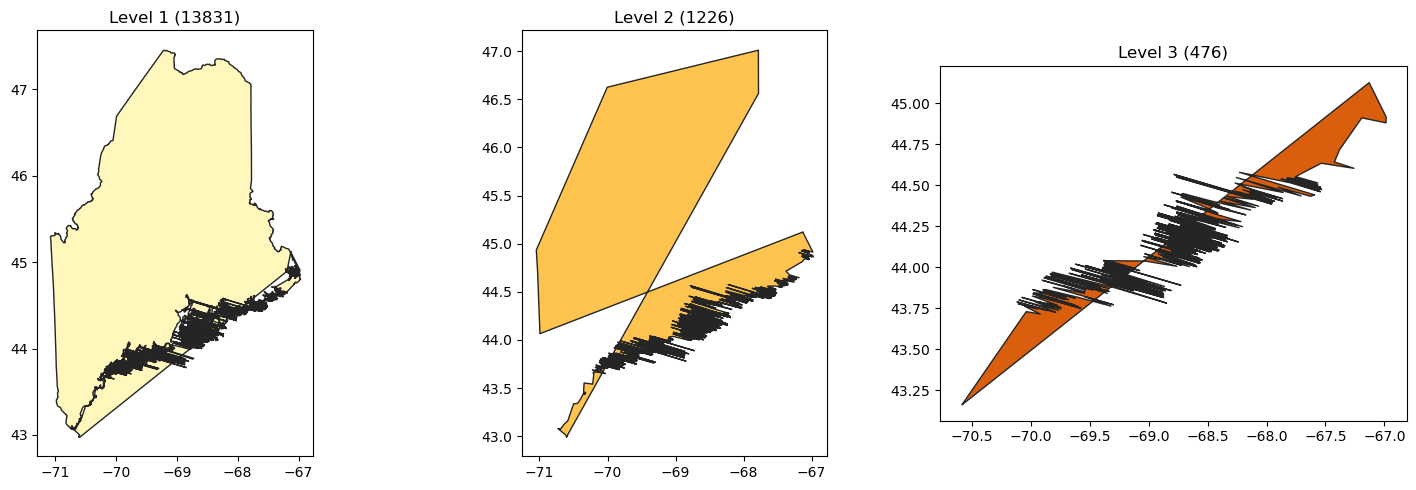

In [79]:
plot_topfers_poly(maine_topfers)

In [89]:
def plot_topfers_concave(topfers_list,svg_fname, tightness1=0.3, tightness2=0.3, tightness3=0.3):
    # Create subplots with three columns
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # Create GeoDataFrame from Topfers list
    gdf1 = coords_to_polygon(topfers_list[0])
    gdf2 = coords_to_polygon(topfers_list[1])
    gdf3 = coords_to_polygon(topfers_list[2])
    # Extract geometries
    geom1 = gdf1.geometry
    geom2 = gdf2.geometry
    geom3 = gdf3.geometry
    # Create hulls with ratios
    s1 = geom1.concave_hull(ratio=tightness1)
    s2 = geom2.concave_hull(ratio=tightness2)
    s3 = geom3.concave_hull(ratio=tightness3)
    # Plot each GeoDataFrame on a separate subplot
    s1.plot(ax=axs[0], color='#fff7bc', edgecolor='#252525')
    axs[0].set_title(f'Level 1 ({len(topfers_list[0])})')
    s2.plot(ax=axs[1], color='#fec44f', edgecolor='#252525')
    axs[1].set_title(f'Level 2 ({len(topfers_list[1])})')
    s3.plot(ax=axs[2], color='#d95f0e', edgecolor='#252525')
    axs[2].set_title(f'Level 3 ({len(topfers_list[2])})')
    # Adjust spacing between subplots
    plt.tight_layout()
    # Show the plot
    plt.show()
    # Save SVG file to path
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = os.path.join('topfers_evaluation_outputs',svg_fname)
    fig.savefig(image_name, format=image_format, dpi=1200)

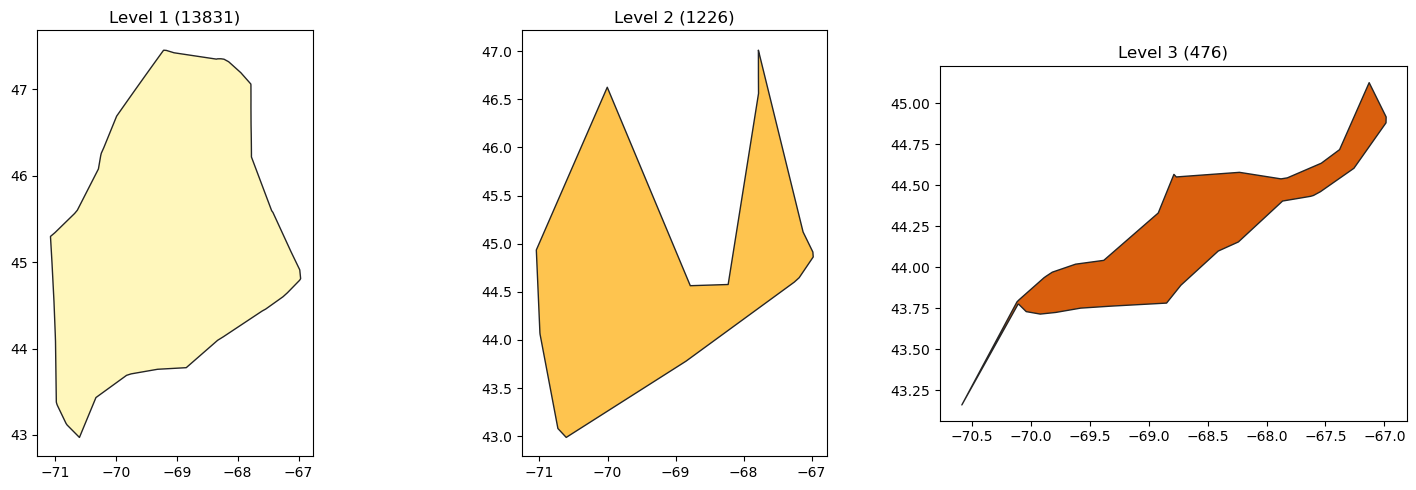

In [91]:
plot_topfers_concave(maine_topfers, svg_fname='Maine_Topfers_L3_ConcaveHull.svg', tightness2=0.9)

In [66]:
tx_topfers = create_topfers(r'Vertices_Labels/Texas.parq')

Level 1: Head (13.64%), Tail (86.36%)
Level 2: Head (9.17%), Tail (90.83%)
Level 3: Head (18.75%), Tail (81.25%)


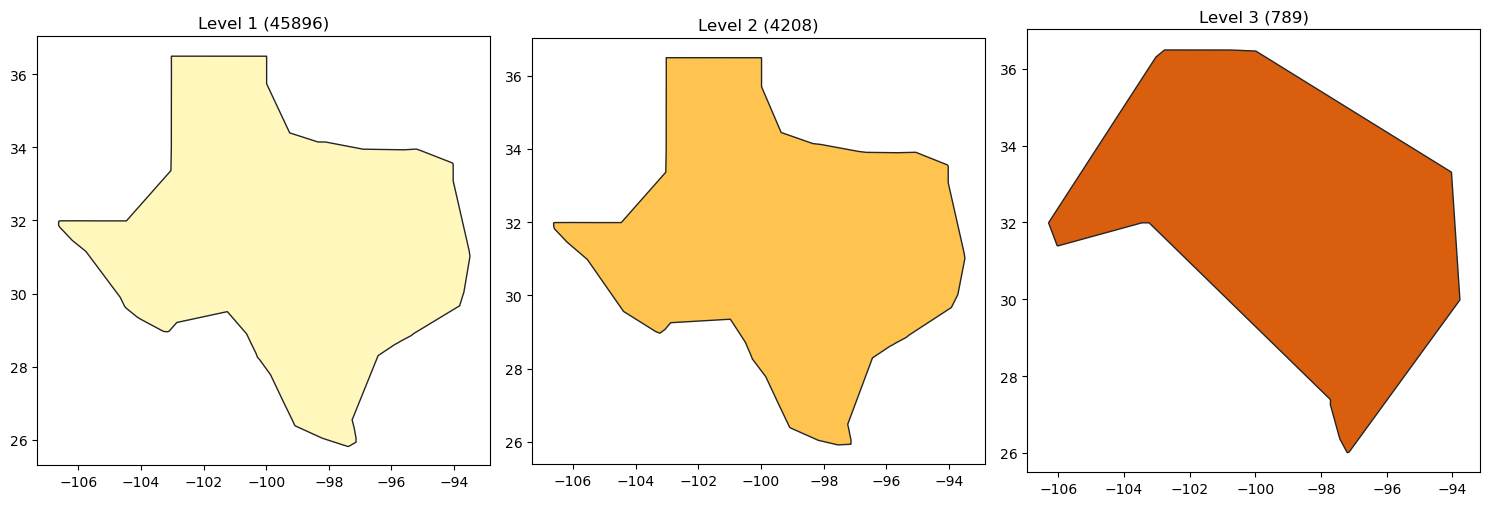

In [93]:
plot_topfers_concave(tx_topfers, svg_fname='Texas_Topfers_L3_ConcaveHull.svg', tightness3=0.7)